In [3]:
"""
Imports.
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import math

from scipy.special import factorial
from scipy.optimize import minimize
from scipy.stats import norm

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import EllipticEnvelope
from sklearn.covariance import LedoitWolf
from sklearn.covariance import MinCovDet

%matplotlib inline
plt.style.use('ggplot')

In [4]:
"""
Data in table.
Only a test dataset.
Available from https://github.com/raphael-group/chisel-data.
"""

calls = pd.read_csv("calls.tsv", sep='\t')
calls

,#CHR,START,END,CELL,NORM_COUNT,COUNT,RDR,A_COUNT,B_COUNT,BAF,CLUSTER,CN_STATE
0,chr1,0,5000000,AAACCTGCACCAAAGG,2654972,547,0.801010,14,23,0.621622,3,1|2
1,chr1,0,5000000,AAACCTGCAGGACCAA,2654972,1340,0.822523,54,26,0.325000,3,2|1
2,chr1,0,5000000,AAACCTGGTAACTTCG,2654972,947,0.874127,43,17,0.283333,3,2|1
3,chr1,0,5000000,AAACCTGGTACCAGTT,2654972,1221,0.826999,47,25,0.347222,3,2|1
4,chr1,0,5000000,AAACCTGGTACCTAGT,2654972,656,1.200903,21,15,0.416667,3,1|1
...,...,...,...,...,...,...,...,...,...,...,...,...
1182745,chr22,50000000,50818468,TTTGTCAAGTAGATGT,488332,409,1.228689,3,3,0.500000,40,2|2
1182746,chr22,50000000,50818468,TTTGTCACAATTCACG,488332,132,0.744681,2,7,0.777778,40,2|2
1182747,chr22,50000000,50818468,TTTGTCATCGAAATCC,488332,212,0.866534,4,4,0.500000,40,1|1
1182748,chr22,50000000,50818468,TTTGTCATCGAACAAA,488332,186,1.249646,3,3,0.500000,40,2|2


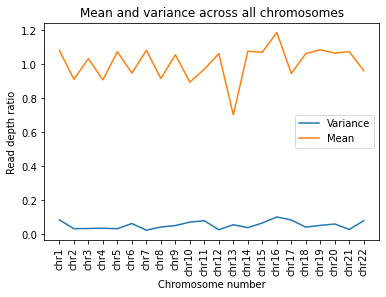

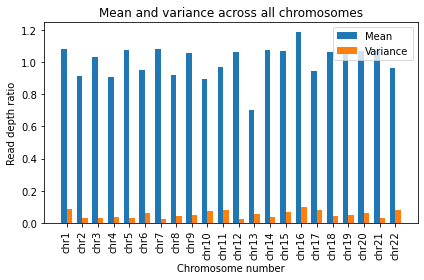

In [80]:
"""Common methods to compute mean and var with .mean and .var."""

all_chr = [chr for chr in calls['#CHR'].unique()]

vardict = {}
meandict = {}
for each_chr in all_chr:
    chrcalls = calls[calls['#CHR'] == each_chr]
    vardict[each_chr] = chrcalls['RDR'].var()
    meandict[each_chr] = chrcalls['RDR'].mean()
    
varseries = pd.Series(vardict)
meanseries = pd.Series(meandict)
    
############

fig, ax = plt.subplots()
ax.plot(varseries, label='Variance')
ax.plot(meanseries, label='Mean')
ax.set_xlabel('Chromosome number')
plt.xticks(rotation=90)
ax.set_ylabel('Read depth ratio')  
ax.set_title("Mean and variance across all chromosomes")  
ax.legend()

############

labels = all_chr
themean = [values for key, values in meandict.items()]
thevariance = [values for key, values in vardict.items()]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots()
rects1 = ax1.bar(x - width/2, themean, width, label='Mean')
rects2 = ax1.bar(x + width/2, thevariance, width, label='Variance')

ax1.set_ylabel('Read depth ratio')
ax1.set_xlabel('Chromosome number')
ax1.set_title('Mean and variance across all chromosomes')
ax1.set_xticks(x)
plt.xticks(rotation=90)
ax1.set_xticklabels(labels)
ax1.legend()

############

fig.tight_layout()


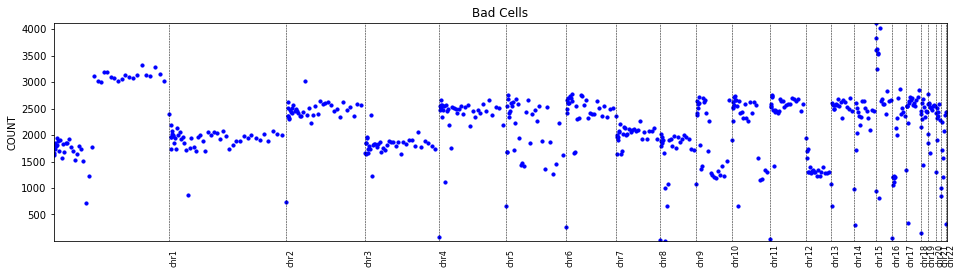

In [81]:
"""Using standard mean and variance to highlight bad quality areas for a random cell.Assume normal."""

newdf = calls

###########

datamean = newdf['COUNT'].mean()
datavar = newdf['COUNT'].var()
datasd = math.sqrt(datavar)

############

badcelldf = newdf[(newdf['COUNT'] < (datamean - 3*datasd)) | (newdf['COUNT'] > (datamean + 3*datasd))]
badcell = random.choice(badcelldf['CELL'].unique())
uniquecell = [cell for cell in badcelldf['CELL'].unique()]

############

df = newdf
df['TOTAL'] = (df['END'] + df['START']).cumsum()
df = df[df['CELL'] == badcell]
experiment = df.drop_duplicates(subset='#CHR', keep='last')
vectordict = dict(zip(experiment['#CHR'], experiment['TOTAL']))

############

fig, ax = plt.subplots(figsize=(16,4))
for key, value in vectordict.items():
    plt.axvline(x=value, linestyle='--', color='k', linewidth=0.5)
    plt.text(value, -450, key, rotation=90, fontsize=8)
df.plot.scatter(x='TOTAL', 
                y='COUNT',
                title='Bad Cells',
                s=10,
                c='Blue', ax=ax)
plt.autoscale(enable=True, axis='both', tight=True)
ax.set_xlabel('')
plt.tick_params(
    axis='x',         
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.show()

                                        

----Accross all chromosomes----

Variance:               577728.4273941349
Variance of 10 samples: 566111.5348073418

----Accross a randomly chosen chromsome---

Variance:               749422.1408948967
Variance of 10 samples: 613064.7919200077


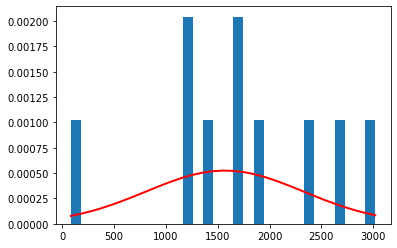

In [82]:
"""Using maximum likelihood estimations."""

# 10 random values for COUNT
mu, sigma = calls['COUNT'].mean(), math.sqrt(calls['COUNT'].var())
s = np.random.normal(mu, sigma, 10)
 # or generaate an array
s1 = np.random.normal(mu, sigma, size= (5,2))
newvariance = np.var(s1)
print('----Accross all chromosomes----')
print(f"\nVariance:               {calls['COUNT'].var()}\nVariance of 10 samples: {newvariance}")

############

# 10 random values for COUNT over only one chromsome
randomchr = calls[calls['#CHR'] == random.choice(calls['#CHR'])]
mu1, sigma1 = randomchr['COUNT'].mean(), math.sqrt(randomchr['COUNT'].var())
s2 = np.random.normal(mu1, sigma1, size= (5,2))
newchrvariance = np.var(s2)
print('\n----Accross a randomly chosen chromsome---')
print(f"\nVariance:               {randomchr['COUNT'].var()}\nVariance of 10 samples: {newchrvariance}")    

############

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

############

# For fitting parameters to samples

#Probability density of normal distribution

# def gaussian(x, mu, sig):
#     return 1./(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

# def lik(x, parameters):
#     mu    = parameters[0]
#     sigma = parameters[1]    
#     n     = len(x)  
#     L     = n/2.0 * np.log(2 * np.pi) + n/2.0 * math.log(sigma **2 ) + 1/(2*sigma**2) * sum([(x_ - mu)**2 for x_ in x ])
#     return L

    
# stdmean    = calls['COUNT'].mean()
# stdsigma = calls['COUNT'].std()

# # use s, random values from normal distribution of COUNT accross all chromosomes
# x = np.random.normal(stdmean, stdsigma, 10)
# x.sort()
# y = gaussian(x, stdmean, stdsigma)


# lik_model = minimize(lik, np.array([stdmean,stdsigma]), method='L-BFGS-B')


# newmu    = lik_model['x'][0]
# newsigma = lik_model['x'][1]

# print(lik_model)
# print(f'New variance: {newsigma**2}')
# plt.plot(x,gaussian(x, newmu, newsigma), label = 'fit')
# plt.plot(x,y, label = 'data')
# plt.legend()


In [5]:
"""My algorithm."""

def gaussian(x, mu, sig):
    return 1./(math.sqrt(2.*math.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def lik(D, x):
    mu, sigma = x    
    n     = len(D)  
    L     = n/2.0 * np.log(2 * np.pi) + n/2.0 * math.log(sigma **2 ) + 1/(2*sigma**2) * sum([(x_ - mu)**2 for x_ in D])
    return L

def algorithm(D):
    stdmean =  np.mean(D)
    stdsigma = np.std(D)
    lik_model = minimize(lambda x : lik(D,x), np.array([stdmean, stdsigma]), method='L-BFGS-B')
    newmu    = lik_model['x'][0]
    newsigma = lik_model['x'][1]
    return newmu, newsigma

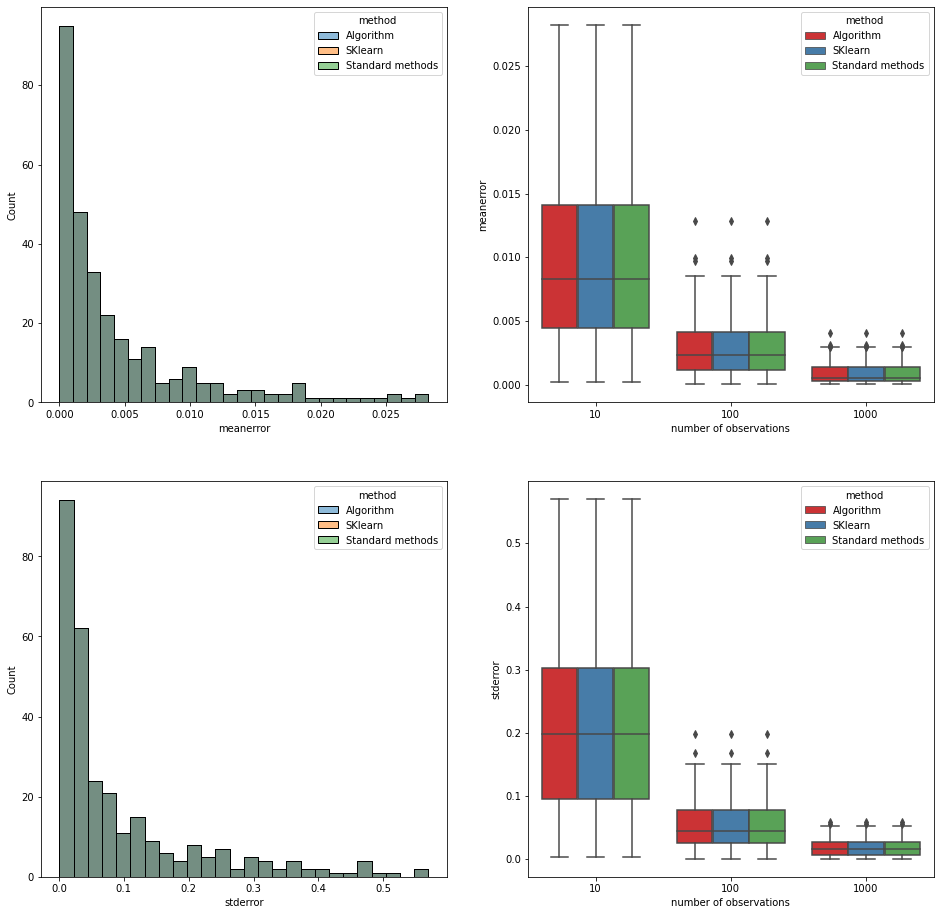

In [84]:
# Myalgorithm == method on SKlearn == standard np methods

myalgorthm_lod = []
truemean = 10000
truestd = 400
for number_observations in [10,100,1000]:
    for repeats in range(1,100):
        Data = np.random.normal(truemean, truestd, number_observations)
        # my algorithm
        results = algorithm(Data)
        meanerror = abs(truemean - results[0]) / truemean
        stderror = abs(truestd - results[1]) / truestd
        myalgorthm_lod.append({'meanerror': meanerror, 'stderror': stderror, 'number of observations': number_observations, 'method': 'Algorithm'})
        # using rvs algorithm from SKlearn
        mu1, sigma1 = norm.fit(Data)
        meanerror1 = abs(truemean - mu1) / truemean
        stderror1 = abs(truestd - sigma1) / truestd
        myalgorthm_lod.append({'meanerror': meanerror1, 'stderror': stderror1, 'number of observations': number_observations, 'method':'SKlearn'})
        # Using built in methods for mean and variance
        mu2 = np.mean(Data)
        sigma2 = np.std(Data)
        meanerror2 = abs(truemean - mu2) / truemean
        stderror2 = abs(truestd - sigma2) / truestd
        myalgorthm_lod.append({'meanerror': meanerror2, 'stderror': stderror2, 'number of observations': number_observations, 'method':'Standard methods'})
mydf = pd.DataFrame(myalgorthm_lod)

fig, axs = plt.subplots(2,2, figsize=(16,16))
sns.histplot(data=mydf, x='meanerror', ax=axs[0,0], hue='method')
sns.boxplot(data=mydf, x='number of observations', y='meanerror', palette='Set1', ax=axs[0,1], hue='method')
sns.histplot(data=mydf, x='stderror', ax=axs[1,0], hue='method')
sns.boxplot(data=mydf, x='number of observations', y='stderror', palette='Set1', ax=axs[1,1], hue='method')

plt.savefig('algo', dpi=300)

<AxesSubplot:xlabel='number of observations', ylabel='stderror'>

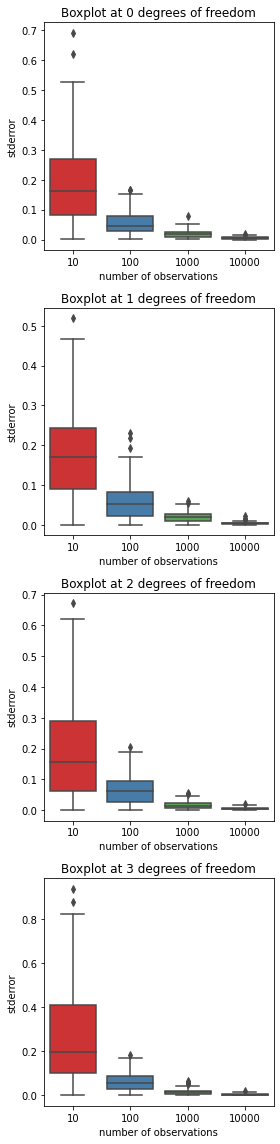

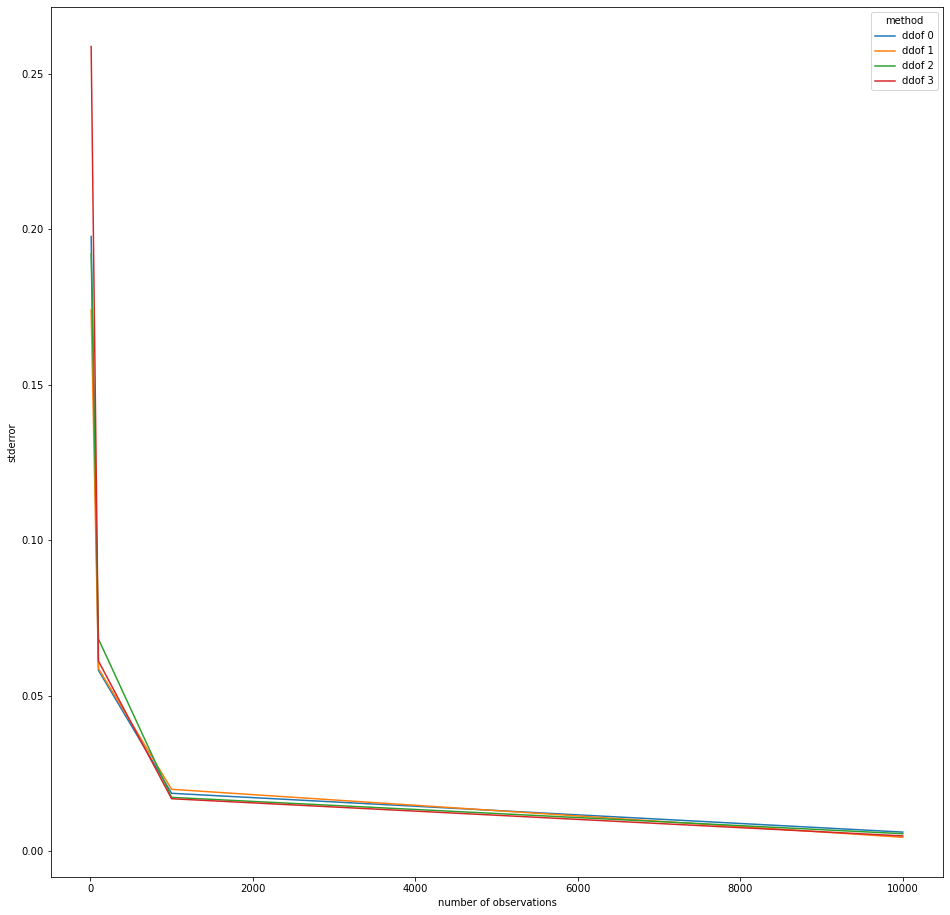

In [85]:
"""Look more closely at np methods."""

new_lod = []
truemean = 10
truestd = 4
for variable in range(0,4):
    for number_observations in [10,100,1000, 10000]:
        for repeats in range(1,100):
            Data = np.random.normal(truemean, truestd, number_observations)
            mean = np.mean(Data)
            std = np.std(Data, ddof=variable)
            meanerror = abs(truemean - mean) / truemean
            stderror = abs(truestd - std) / truestd
            new_lod.append({'meanerror': meanerror, 'stderror': stderror, 'number of observations': number_observations, 'method': f'ddof {variable}'})
df = pd.DataFrame(new_lod)

fig, axs = plt.subplots(4,1, figsize=(4,16))
for e in range(0,4):
    sns.boxplot(data=df[df['method'] == f'ddof {e}'],
                x='number of observations',
                y='stderror',
                palette='Set1',
                ax=axs[e])
    axs[e].set_title(f'Boxplot at {e} degrees of freedom')
    plt.tight_layout()
    plt.plot()
fig, ax = plt.subplots(figsize=(16,16))
sns.lineplot(data=df, x='number of observations', y='stderror', hue='method', ci=None)


In [2]:
lod = []
truemean = 10
truestd = 4
for variable in [0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,100]:
    for number_observations in [10, 100, 1000, 10000, 100000]:
        for repeats in range(1,1000):
            Data = np.random.normal(truemean, truestd, number_observations)
            mean = np.mean(Data)
            std = np.std(Data, ddof=variable)
            meanerror = abs(truemean - mean) / truemean
            stderror = abs(truestd - std) / truestd
            lod.append({'meanerror': meanerror,
                        'stderror': stderror,
                        'number of observations': number_observations,
                        'method': f'ddof {variable}'})
df = pd.DataFrame(lod)


fig, axs = plt.subplots(5,1)
n = 0
for e in [10, 100, 1000, 10000, 100000]:
    sns.boxplot(data=df[df['number of observations'] == e],
                x='number of observations',
                y='stderror',
                hue='method',
                palette='Set1',
                ax=axs[n])
    n += 1

NameError: name 'np' is not defined

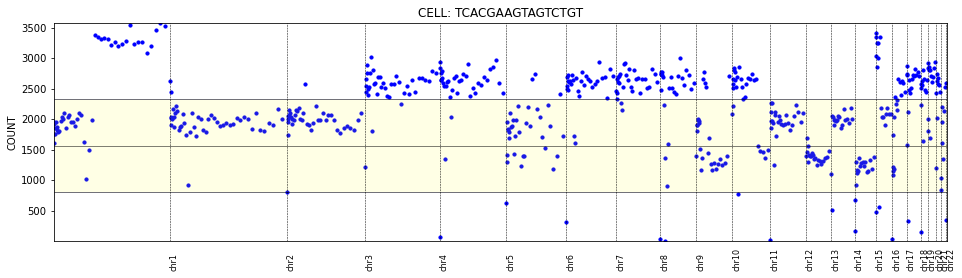

In [95]:
"""Choose a cell."""
copydf = calls.copy()
mycell = random.choice(copydf['CELL'])

"""Mean and std."""
mean = np.mean(calls['COUNT'])
std = np.std(calls['COUNT'], ddof=1)

"""Graph the cell."""
copydf['TOTAL'] = (copydf['END'] + copydf['START']).cumsum()
copydf = copydf[copydf['CELL'] == mycell]
chrlength = copydf.drop_duplicates(subset='#CHR', keep='last')
chrlengthdict = dict(zip(chrlength['#CHR'], chrlength['TOTAL']))

fig, ax = plt.subplots(figsize=(16,4))
for key, value in chrlengthdict.items():
    plt.axvline(x=value, linestyle='--', color='k', linewidth=0.5)
    plt.text(value, -450, key, rotation=90, fontsize=8)
plt.axhline(y=mean, c='k', linewidth=0.5)
plt.axhline(y=mean + std, c='k', linewidth=0.5)
plt.axhline(y=mean - std, c='k', linewidth=0.5)
ax.axhspan(ymin=mean - std, ymax=mean + std, alpha=0.1, facecolor='yellow', edgecolor='blue')
copydf.plot.scatter(x='TOTAL', 
                    y='COUNT',
                    title=f'CELL: {mycell}',
                    s=10,
                    c='Blue',
                    ax=ax)
plt.autoscale(enable=True, axis='both', tight=True)
ax.set_xlabel('')
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.show()



In [ ]:
"""COMP00142 methods."""

"""Create train and test sets."""
seq = calls.copy()
training_set, testing_set = train_test_split(seq, test_size=0.2, random_state=42)

"""Standardise the data (COUNT)."""
scaler = StandardScaler()
training_set = scaler.fit_transform(training_set)
testing_set = scaler.transform(testing_set)

"""Compute MAE and MSE."""


In [10]:
new_lod = []
truemean = 1
truestd = 0.4
for number_observations in [10,100,1000]:
    for repeats in range(1,2):
        Data = np.random.normal(truemean, truestd, number_observations)
        # my algorithm
        results = algorithm(Data)
        print(results[0], results[1])
        meanerror = abs(truemean - results[0]) / truemean
        stderror = abs(truestd - results[1]) / truestd
        new_lod.append({'meanerror': meanerror, 'stderror': stderror, 'number of observations': number_observations, 'method': 'Algorithm'})
        # using rvs algorithm from SKlearn
        mu1, sigma1 = norm.fit(Data)
        print(mu1, sigma1)
        meanerror1 = abs(truemean - mu1) / truemean
        stderror1 = abs(truestd - sigma1) / truestd
        new_lod.append({'meanerror': meanerror1, 'stderror': stderror1, 'number of observations': number_observations, 'method':'SKlearn'})
        # Using built in methods for mean and variance
        mu2 = np.mean(Data)
        sigma2 = np.std(Data)
        print(mu2, sigma2)
        meanerror2 = abs(truemean - mu2) / truemean
        stderror2 = abs(truestd - sigma2) / truestd
        new_lod.append({'meanerror': meanerror2, 'stderror': stderror2, 'number of observations': number_observations, 'method':'Standard methods'})
mydf = pd.DataFrame(new_lod)

1.1157518082400437 0.4282836672418823
1.1157518082400437 0.4282836672418823
1.1157518082400437 0.4282836672418823
1.0103007590264632 0.3803568169699608
1.0103007590264632 0.3803568169699608
1.0103007590264632 0.3803568169699608
0.9732140337073422 0.3849336965026338
0.9732140337073422 0.3849336965026338
0.9732140337073422 0.3849336965026338


In [ ]:
"""
----Methods----
Often times covariance is calculated instead of varaince but since VAR(X) = COVAR(X,X), for univariate uniform guassions
the covariance is the variance.
Most of these rely on covariance calculators from SKlearn.
'ML'         - is a maximum likelihood method.
'GMM'        - is a gaussian mixture mdodel. The default assumed normals is one, using anything more than this is mostlikely
               pointless as all the observations come from a uniform normal distribution. Better to test this on an actual
               sample of counts across the cell?
'BGMM'       - is a bayesian gaussian mixture model. Again the sample problem applies.
'EC'         - is the empirical covariance. This is also a maximum likelihood estimate.
'EE'         - is the eliptical envelope, useful for detecting outliers, but included anyway.
'LEDOIT WOLF'- calculates estimates using shrinkage.
'MINCOVDET'  - is minimum covariance determinant. Good robust estimator of covariance; uses empiral covariance.
There are a lot of hyperparams that  can be tweaked.
"""
true_mean, true_std = 1, 0.4
errors = []
methods = ['ML', 'GMM', 'BGMM', 'EC', 'EE', 'LEDOIT WOLF', 'MINCOVDET']
for method in methods:
    for observations in [10, 100, 1000, 10000]:
        for repeats in range(1,1001):
            Data = np.random.normal(true_mean, true_std, observations)
            if method == 'ML':
                mu, sigma = norm.fit(Data)
            elif method == 'GMM':
                gm = GaussianMixture().fit(Data.reshape(-1,1))
                mu, sigma = gm.means_[0][0], math.sqrt(gm.covariances_[0][0])
            elif method == 'BGMM':
                bgm = BayesianGaussianMixture().fit(Data.reshape(-1,1))
                mu, sigma = bgm.means_[0][0], math.sqrt(bgm.covariances_[0][0])
            elif method == 'EC':
                cov = EmpiricalCovariance().fit(Data.reshape(-1,1))
                mu, sigma = cov.location_[0], math.sqrt(cov.covariance_[0])
            elif method == 'EE':
                cov = EllipticEnvelope().fit(Data.reshape(-1,1))
                mu, sigma = cov.location_[0], math.sqrt(cov.covariance_[0])
            elif method == 'LEDOIT WOLF':
                cov = LedoitWolf().fit(Data.reshape(-1,1))
                mu, sigma = cov.location_[0], math.sqrt(cov.covariance_[0])
            elif method == 'MINCOVDET':
                cov = MinCovDet().fit(Data.reshape(-1,1))
                mu, sigma = cov.location_[0], math.sqrt(cov.covariance_[0])
            mean_error = abs((true_mean - mu) / true_mean)
            std_error = abs((true_std - sigma) / true_std)
            errors.append({'Mean error': mean_error, 'Standard deviation error': std_error, 'Observations':observations, 'Method': method})
df = pd.DataFrame(errors)
fig, axs = plt.subplots(2,4, figsize=(16,16), tight_layout=True)
for number, value in enumerate([10,100,1000,10000]):
    sns.boxplot(data=df[df['Observations'] == value], x='Observations', y='Mean error', hue='Method', palette='Set1', ax=axs[0, number])
    axs[0, number].legend(loc=2, fontsize='x-small', ncol=2, title='Legend (method used)')
    sns.boxplot(data=df[df['Observations'] == value], x='Observations', y='Standard deviation error', hue='Method', palette='Set1', ax=axs[1,number])
    axs[1, number].legend(loc=2, fontsize='x-small', ncol=2, title='Legend (method used)')